# ENOT: Expectile Regularization for Fast and Accurate Training of Neural Optimal Transport

{class}`~ott.neural.solvers.expectile_neural_dual.ExpectileNeuralDual` solves the dual OT problem where the objective is a sum 
of Kantorovich potential functions with additional expectile regularization {cite}`buzun:24`. Initialization arguments includes potential models that inherit {class}`~flax.linen.Module`, a cost function of type {class}`~ott.geometry.costs.CostFn` `is_bidirectional` boolean parameter that indicates whether we train the OT mapping in both directions, and two regularization parameters (`expectile` and `expectile_loss_coef`). The training procedure returns object {class}`~ott.problems.linear.potentials.DualPotentials` that can be used to transport between input distributions or compute the corresponding OT distance between them. 

In [3]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import dataclasses
from typing import Any, Callable, Iterator, Literal, Mapping, Optional, Sequence, Tuple

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import jax
import jax.numpy as jnp
import numpy as np
import optax
import sklearn

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from ott import datasets
from ott.datasets import Dataset
from ott.geometry import costs, pointcloud
from ott.neural.solvers.expectile_neural_dual import MLP, ExpectileNeuralDual
from ott.tools import sinkhorn_divergence

## Evaluation on synthetic 2D datasets

In this section we show how ENOT finds optimal map between two measures constructed from {cite}`makkuva:20`. Here, we utilize `~ott.datasets.create_gaussian_mixture_samplers` in order to get samples from source measure `square_five` and target measure `square_four`.
In experiments we use a custom implementation of `MLP` for the potential models. Under the hood optimization is done with respect to the type of cost function (for example `DotCost` or a translation invariant cost `TICost`).

Also, we additionally use `plotly` library for visualizations, which can be installed via `pip install plotly`.

In [3]:
num_samples_visualize = 512
(
    train_dataloaders,
    valid_dataloaders,
    input_dim,
) = datasets.create_gaussian_mixture_samplers(
    name_source="square_five",
    name_target="square_four",
    valid_batch_size=num_samples_visualize,
    train_batch_size=2048,
)

eval_data_source = next(valid_dataloaders.source_iter)
eval_data_target = next(valid_dataloaders.target_iter)

In [48]:
from turtle import width


def plot_eval_samples(
    eval_data_source,
    eval_data_target,
    pushforward=None,
    title="Examples of two measures",
):
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(
        go.Scatter(
            x=eval_data_source[:, 0],
            y=eval_data_source[:, 1],
            mode="markers",
            marker_color="LightSkyBlue",
            name="Source",
            marker=dict(size=8, line=dict(width=0.8, color="black")),
        ),
        row=1,
        col=1,
    )

    if pushforward is not None:
        fig.add_trace(
            go.Scatter(
                x=pushforward[:, 0],
                y=pushforward[:, 1],
                mode="markers",
                marker_color="red",
                name="Transported source",
                marker=dict(size=8, line=dict(width=0.8, color="black")),
            ),
            row=1,
            col=2,
        )
    fig.add_trace(
        go.Scatter(
            x=eval_data_target[:, 0],
            y=eval_data_target[:, 1],
            mode="markers",
            marker_color="green",
            name="Target",
            opacity=0.45,
            marker=dict(size=8, line=dict(width=0.8, color="black")),
        ),
        row=1,
        col=2,
    )
    fig.update_layout(title_text=title, title_font_size=20, title_x=0.5)
    fig.update_layout(
        legend=dict(yanchor="top", y=1.15, xanchor="left", x=0, orientation="h")
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()

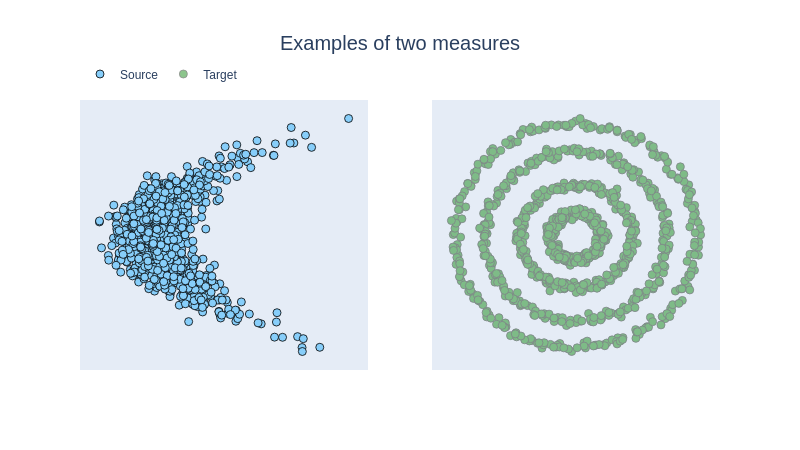

In [59]:
import plotly.io as pio

png_renderer = pio.renderers["png"]
png_renderer.width = 800
png_renderer.height = 450
pio.renderers.default = "png"

plot_eval_samples(eval_data_source, eval_data_target)

In [11]:
num_train_iters = 90_001


def training_callback(step, learned_potentials):
    if step % 2500 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        neural_dual_dist = learned_potentials.distance(
            eval_data_source, eval_data_target
        )
        print(
            f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
        )

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=False,
        )
        display(fig)
        plt.close(fig)

## Training

Here, by setting `is_bidirectional` flag in `ExpectileNeuralDual` class to `True`, we compute OT in back and forth fashion. The main hyperparameters to look at are `expectile` and `expectile_loss_coef`, denoted in paper as $\tau$ and $\lambda$ respectively.

Training iteration: 90000/90001
Neural dual distance between source and target data: 21.23


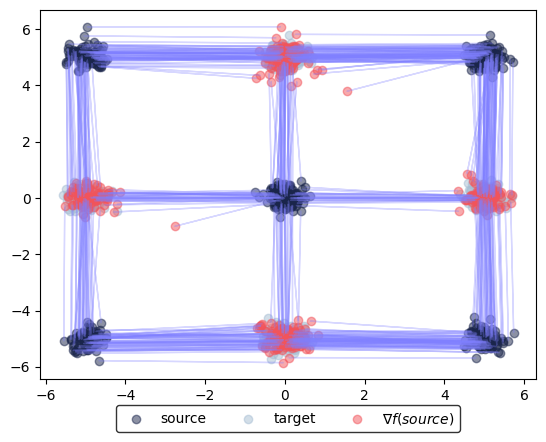

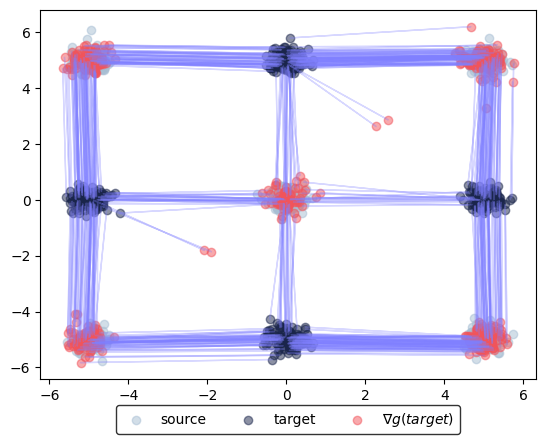

In [17]:
neural_f = MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.gelu)
neural_g = MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.gelu)

lr_schedule_f = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.999)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.999)

neural_dual_solver = ExpectileNeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    cost_fn=costs.SqEuclidean(),
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=0.3,
    rng=jax.random.PRNGKey(3),
    is_bidirectional=True,
)
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
    callback=training_callback,
)

## Evaluation

In [8]:
@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    return sdiv.divergence

In [18]:
pred_target = learned_potentials.transport(eval_data_source)
print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_loss(pred_target, eval_data_target):.2f}"
)

pred_source = learned_potentials.transport(eval_data_target, forward=False)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_source, eval_data_source):.2f}"
)

neural_dual_dist = learned_potentials.distance(
    eval_data_source, eval_data_target
)
print(
    f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
)

sinkhorn_dist = sinkhorn_loss(eval_data_source, eval_data_target)
print(f"Sinkhorn distance between source and target data: {sinkhorn_dist:.2f}")

Sinkhorn distance between target predictions and data samples: 0.08
Sinkhorn distance between source predictions and data samples: 0.13
Neural dual distance between source and target data: 21.23
Sinkhorn distance between source and target data: 21.24


## MAFMoons & Rings synthetic datasets

Below we show how ENOT handles more challenging tasks. For such case we implement `MAFMoonSampler` and `RingSampler` data samplers.

In [50]:
@dataclasses.dataclass
class MAFMoonSampler:
    def __init__(self, size):
        self.size = size

    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        x = jax.random.normal(key, shape=[batch_size, 2])
        x = x.at[:, 0].add(x[:, 1] ** 2)
        x = x.at[:, 0].mul(0.5)
        x = x.at[:, 0].add(-5)
        return x


@dataclasses.dataclass
class RingSampler:
    def __init__(self, size):
        self.size = size

    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        n_samples4 = n_samples3 = n_samples2 = batch_size // 4
        n_samples1 = batch_size - n_samples4 - n_samples3 - n_samples2

        linspace4 = jnp.linspace(0, 2 * jnp.pi, n_samples4, endpoint=False)
        linspace3 = jnp.linspace(0, 2 * jnp.pi, n_samples3, endpoint=False)
        linspace2 = jnp.linspace(0, 2 * jnp.pi, n_samples2, endpoint=False)
        linspace1 = jnp.linspace(0, 2 * jnp.pi, n_samples1, endpoint=False)

        circ4_x = jnp.cos(linspace4) * 1.2
        circ4_y = jnp.sin(linspace4) * 1.2
        circ3_x = jnp.cos(linspace4) * 0.9
        circ3_y = jnp.sin(linspace3) * 0.9
        circ2_x = jnp.cos(linspace2) * 0.55
        circ2_y = jnp.sin(linspace2) * 0.55
        circ1_x = jnp.cos(linspace1) * 0.25
        circ1_y = jnp.sin(linspace1) * 0.25

        X = (
            jnp.vstack(
                [
                    jnp.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
                    jnp.hstack([circ4_y, circ3_y, circ2_y, circ1_y]),
                ]
            ).T
            * 3.0
        )
        X = sklearn.utils.shuffle(X)

        # Add noise
        X = X + jax.random.normal(key, shape=X.shape) * 0.08

        return X.astype("float32")

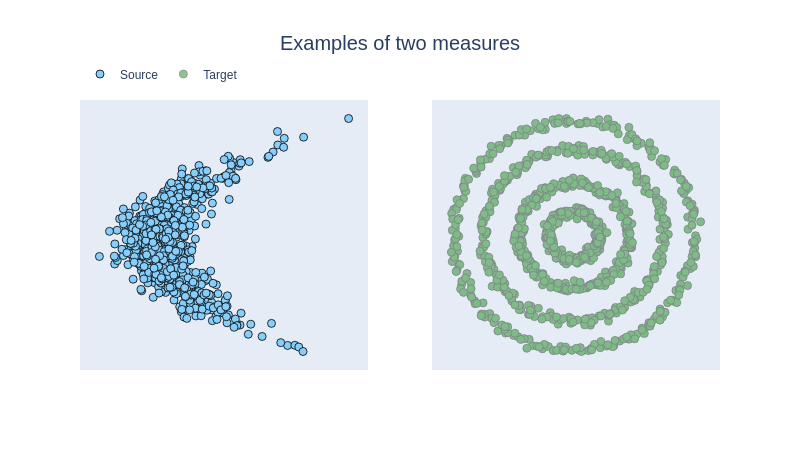

In [60]:
train_loader = Dataset(
    source_iter=iter(MAFMoonSampler(size=1024)),
    target_iter=iter(RingSampler(size=1024)),
)
valid_loader = train_loader

moon_samples = next(train_loader.source_iter)
ring_samples = next(train_loader.target_iter)

plot_eval_samples(moon_samples, ring_samples)

In [54]:
eval_data_source = next(valid_loader.source_iter)
eval_data_target = next(valid_loader.target_iter)

neural_f = MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.elu)
neural_g = MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.elu)

num_train_iters = 90_001
lr_schedule_f = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-3
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-3
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.999)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.999)

neural_dual_solver = ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    cost_fn=costs.SqEuclidean(),
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=0.3,
    rng=jax.random.PRNGKey(4),
    is_bidirectional=True,
)
learned_potentials = neural_dual_solver(*train_loader, *valid_loader)

  0%|          | 0/90001 [00:00<?, ?it/s]

Evaluate `learned_potentials`

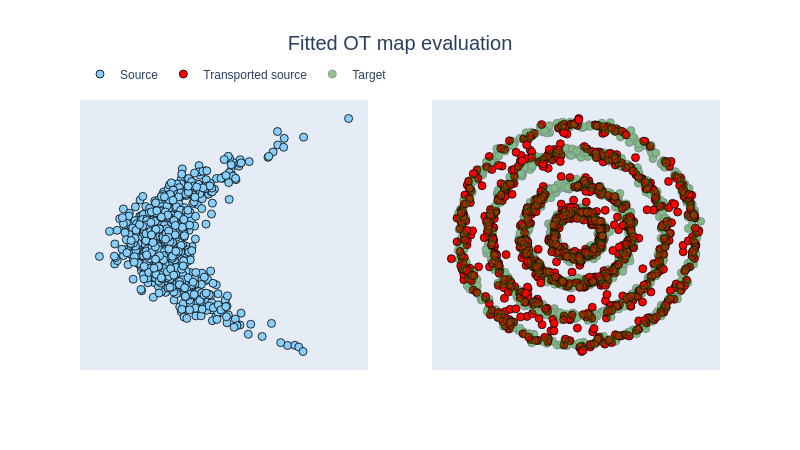

In [61]:
plot_eval_samples(
    moon_samples,
    ring_samples,
    learned_potentials.transport(moon_samples),
    title="Fitted OT map evaluation",
)

## Different costs on 2D data

Below we show how ENOT performs with varying underlying cost function $c(x, y)$ on synthetic 2d datasets `HalfMoon` and `S_curve`.

In [57]:
from types import MappingProxyType

import sklearn.datasets


@dataclasses.dataclass
class SklearnDistribution:
    name: Literal["moon", "s_curve"]
    theta_rotation: float = 0.0
    mean: Optional[jnp.ndarray] = None
    noise: float = 0.01
    scale: float = 1.0
    batch_size: int = 1024
    rng: Optional[jax.Array] = None

    def __iter__(self) -> Iterator[jnp.ndarray]:
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = jax.random.PRNGKey(0) if self.rng is None else self.rng
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=(self.batch_size, 0),
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                x, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = x[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            mean = jnp.zeros(2) if self.mean is None else self.mean
            samples = mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = 256,
    valid_batch_size: int = 256,
    rng: Optional[jax.Array] = None,
):

    rng = jax.random.PRNGKey(0) if rng is None else rng
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data

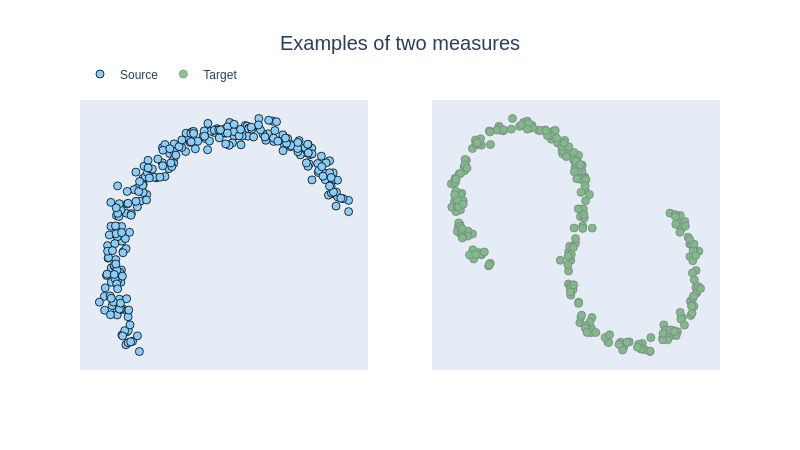

In [62]:
train_dataset, valid_dataset, dim_data = create_samplers(
    source_kwargs={
        "name": "moon",
        "theta_rotation": jnp.pi / 6,
        "mean": jnp.array([0.0, -0.5]),
        "noise": 0.05,
    },
    target_kwargs={
        "name": "s_curve",
        "scale": 0.6,
        "mean": jnp.array([0.5, -2.0]),
        "theta_rotation": -jnp.pi / 6,
        "noise": 0.05,
    },
)

train_source = next(train_dataset.source_iter)
train_target = next(train_dataset.target_iter)
plot_eval_samples(train_source, train_target)

Training iteration: 25000/25001
Neural dual distance between source and target data: 2.28


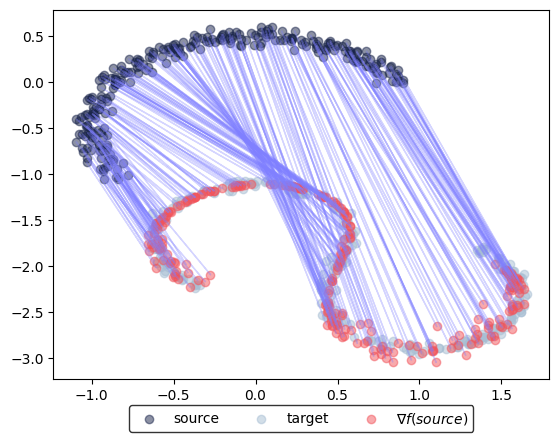

In [45]:
neural_f = MLP(dim_hidden=[64, 64, 64, 2], act_fn=jax.nn.gelu)
neural_g = MLP(dim_hidden=[64, 64, 64, 1], act_fn=jax.nn.gelu)

num_train_iters = 25_001

lr_schedule_f = optax.cosine_decay_schedule(
    init_value=3e-4, decay_steps=num_train_iters, alpha=1e-4
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=3e-4, decay_steps=num_train_iters, alpha=1e-4
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.999)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.999)


neural_dual_solver = ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=1,
    cost_fn=costs.Euclidean(),
    rng=jax.random.PRNGKey(42),
    is_bidirectional=False,
)

sample_data_source = next(train_dataset.source_iter)
sample_data_target = next(train_dataset.target_iter)


def training_callback(step, learned_potentials):
    if step % 5_000 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        neural_dual_dist = learned_potentials.distance(
            sample_data_source, sample_data_target
        )
        print(
            f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
        )

        fig, ax = learned_potentials.plot_ot_map(
            sample_data_source,
            sample_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)


learned_potentials = neural_dual_solver(
    *train_dataset, *valid_dataset, callback=training_callback
)

Change the cost to squared Euclidean and visualize results:

Training iteration: 25000/25001
Neural dual distance between source and target data: 4.78


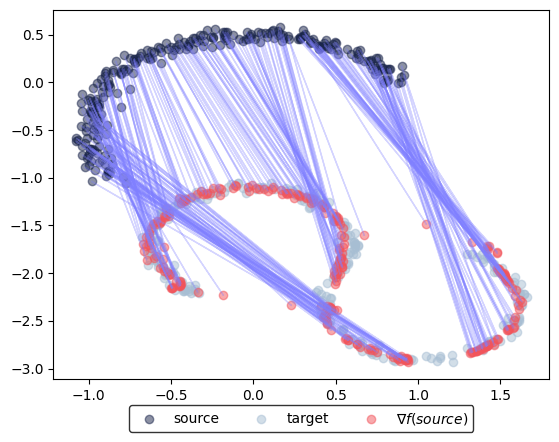

In [46]:
neural_dual_solver = ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=1,
    cost_fn=costs.SqEuclidean(),
    rng=jax.random.PRNGKey(42),
    is_bidirectional=False,
)

sample_data_source = next(train_dataset.source_iter)
sample_data_target = next(train_dataset.target_iter)

learned_potentials = neural_dual_solver(
    *train_dataset, *valid_dataset, callback=training_callback
)

Training iteration: 25000/25001
Neural dual distance between source and target data: 2.57


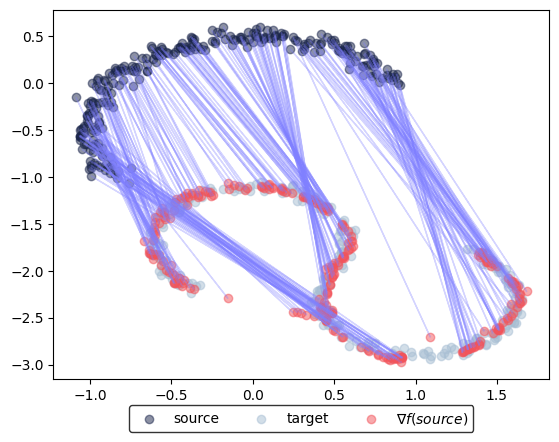

In [48]:
neural_dual_solver = ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=1,
    cost_fn=costs.PNormP(1.5),
    rng=jax.random.PRNGKey(42),
    is_bidirectional=False,
)

sample_data_source = next(train_dataset.source_iter)
sample_data_target = next(train_dataset.target_iter)

learned_potentials = neural_dual_solver(
    *train_dataset, *valid_dataset, callback=training_callback
)